# Large-scale Collective Matrix Factorization (lsCMF)

This is a package implementing the data integration methodology described in 
["Large-scale Data Integration using Matrix Denoising and
Geometric Factor Matching" (Held, 2024, arXiv:2405.10036 \[stat.ME\])](https://arxiv.org/abs/2405.10036).

## Install development version

To install the development version of the package run

```sh
pip install git+https://github.com/cyianor/lscmf.git
```

## Install stable version

To install the stable version of the package run

```sh
pip install lscmf
```

## Usage example

A simple usage example is shown below:

In [38]:
import lscmf
from numpy.random import default_rng

# Control randomness
rng = default_rng(42)

# Simulate some data
# - `viewdims`: Dimensions of each view
# - `factor_scales`: The strength/singular value of each factor. 
#                    The diagonal of the D matrices in the paper.
# - `snr`: Signal-to-noise ratio of the noise added to each true signal
#
# The function below generates orthogonal matrices V_i and uses the
# supplied D_ij to form signal matrices V_i D_ij V_j^T. Noise with
# residual variance controlled by the signal-to-noise ratio is added.
xs_sim = lscmf.simulate(
    viewdims={0: 500, 1: 250, 2: 250},
    factor_scales={
        (0, 1): [3.0, 2.5, 2.0, 0.0, 0.0],
        (0, 2): [2.8, 0.0, 0.0, 2.0, 0.0],
        (1, 2): [1.2, 0.0, 5.0, 0.0, 1.1],
    },
    snr=1.0,
    rng=rng,
)

# `xs_sim` is a dictionary containing
# - "xs_truth", the true signal matrices
# - "xs", the noisy data
# - "vs", the simulated orthogonal factors

# Create the lscmf object and fit the model to data
est = lscmf.LargeScaleCMF().fit(xs_sim["xs"])

Estimates of model parameters are then contained in the `LargeScaleCMF` object.
The estimated singular values can be accessed as shown below.

In [39]:
est.ds_

{(0,
  1): array([ 2.98687823, -1.96015864,  0.        ,  0.        ,  2.47498787]),
 (0,
  2): array([-2.78861131,  0.        ,  0.        ,  1.96604697,  0.        ]),
 (1,
  2): array([-1.13272996,  4.98917765, -1.00988163,  0.        ,  0.        ])}

The estimated factors can be accessed as follows, e.g., for view 0 the first factor is

Scalar product between estimated and true factor: -0.95


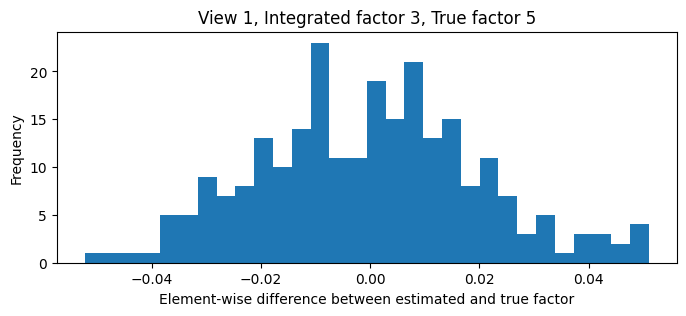

In [53]:
import matplotlib.pyplot as plt

cos_angle = (est.vs_[1][:, 2] * xs_sim["vs"][1][:, 4]).sum()
print(f"Scalar product between estimated and true factor: {cos_angle:.2f}")

fig = plt.figure(figsize=(8, 3), dpi=100)
ax = fig.add_subplot(111)
# Negate integrated factor since it was estimated as -v instead of v
ax.hist((-est.vs_[1][:, 2]) - xs_sim["vs"][1][:, 4], bins=30)
ax.set_xlabel("Element-wise difference between estimated and true factor")
ax.set_ylabel("Frequency");
ax.set_title("View 1, Integrated factor 3, True factor 5");

A raw graph-based interface exists as well.

In [61]:
# Create a view graph to hold the data layout
G = lscmf.ViewGraph()
# Add data
# - `names` need to be provided as an iterable.
#   These are in general arbitrary, however, in case of
#   repeated layers, each layer requires a unique name.
# - `xs` is an iterable to the input data in the same order as
#   `names`
# - `viewrels` is an iterable containing tuples describing the
#    relationships between views contained in data matrices.
G.add_data_from(["x01", "x02", "x12"], xs_sim["xs"].values(), [(0, 1), (0, 2), (1, 2)])

# Once data is added to the view graph, joint matrices for each
# view need to be formed and denoising needs to be performed.
# Different types of shrinkers can be used for denoising and they
# depend on the type of loss assumed for reconstruction of the
# signal. See Gavish and Donoho (2017) for details.
# In the paper, Frobenius loss is assumed, and therefore the resulting
# `FrobeniusShrinker` is used here.
lscmf.precompute(G, lscmf.FrobeniusShrinker)

# Finally, matching of factors for each view and merging of the
# factor match graphs is performed. This function returns
# the final merged factor match graph.
H = lscmf.match_factors(G)

Matches in the factor match graph can be investigated. `MatchNode`s contain a `data_edge`, which is a `MultiEdge(name, viewrel)` corresponding to an input matrix during view graph construction, and a `factor` which is the factor in the `data_edge`. Keys of the dictionary are integrated factors.

In the example below, `MatchNode(data_edge=MultiEdge(x01, (0, 1)), factor=0)` is the first factor in data matrix $X_{01}$ which is being associated with integrated factor 0.

The numbering of integrated factors is arbitrary and may be non-consecutive.

In [62]:
H.graph

defaultdict(set,
            {0: {MatchNode(data_edge=MultiEdge(x01, (0, 1)), factor=0),
              MatchNode(data_edge=MultiEdge(x02, (0, 2)), factor=0),
              MatchNode(data_edge=MultiEdge(x12, (1, 2)), factor=1)},
             2: {MatchNode(data_edge=MultiEdge(x02, (0, 2)), factor=1)},
             1: {MatchNode(data_edge=MultiEdge(x01, (0, 1)), factor=2),
              MatchNode(data_edge=MultiEdge(x12, (1, 2)), factor=0)},
             3: {MatchNode(data_edge=MultiEdge(x12, (1, 2)), factor=2)},
             4: {MatchNode(data_edge=MultiEdge(x01, (0, 1)), factor=1)}})

Reconstruction of $D_{ij}$ and $V_i$ is performed in `LargeScaleCMF.fit()` and it is recommended to use that interface unless the graph interface is required for a specific reason.